In [1]:
try:
    import netket as nk
except ImportError:
    !pip install --quiet --upgrade netket
    import netket as nk

from netket.operator.spin import sigmax, sigmaz

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.sparse.linalg import eigsh
from numba import njit

matplotlib.rcParams.update({'font.size': 12})
np.random.seed(123)

# 0. Introduction

The hamiltonian of the transverse field Ising model is given by $$ \mathcal{H} = \Gamma \sum_j \sigma_i^z \sigma_{i+1}^z + V \sum_j \sigma^x,$$ where $\sigma^k$ are the pauli operators. We assume periodic boundary conditions.  

# 1. Exact diagonalization <a class="anchor" id="chapter1"></a>


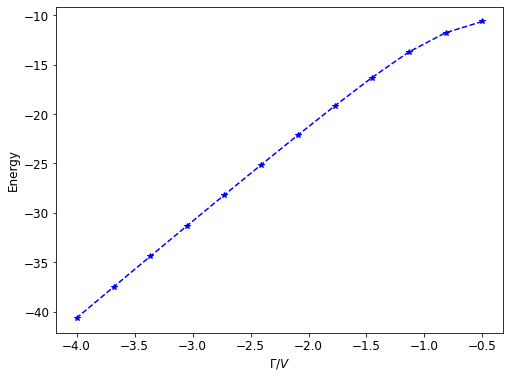

Energies_gs = [-10.63560441 -11.77550895 -13.73238057 -16.32729303 -19.16905047
 -22.12312939 -25.14039969 -28.19739083 -31.28113632 -34.38380987
 -37.50038571 -40.6274812 ]


In [2]:
n_spins = 10
hi = nk.hilbert.Spin(s=1/2, N=n_spins)
V=-1

def get_hamiltonian(V, Gamma, hi, pbc=True):
    if pbc:
        final_index = hi.size
    else:
        final_index = hi.size - 1
    H_int = sum([V*sigmaz(hi,i)*sigmaz(hi,(i+1)%hi.size) for i in range(final_index)])
    H_ext = sum([Gamma*sigmax(hi,j) for j in range(hi.size)])
    return H_int + H_ext
    
n_Gamma = 12
Gamma_vals = np.linspace(-0.5,-4,n_Gamma)
Energies_gs = np.zeros(n_Gamma)

for i, Gamma in enumerate(Gamma_vals):
    H = get_hamiltonian(V, Gamma, hi)
    sp_h=H.to_sparse()
    eig_vals, eig_vecs = eigsh(sp_h, k=1, which="SA")
    Energies_gs[i] = eig_vals[0]

plt.figure(figsize=(8,6))
plt.plot(Gamma_vals, Energies_gs, 'b*--')
plt.xlabel(r'$\Gamma/V$')
plt.ylabel('Energy')
plt.show()

print('Energies_gs =', Energies_gs)

# 2. Neural quantum states <a class="anchor" id="chapter2"></a>

## 2.1 Numpy (and numba) <a class="anchor" id="numpy"></a>

In [3]:
def get_connected(x, Gamma):
    n_spins = x.shape[0]
    
    # diagonal element
    Xp = np.array(x).reshape(1, n_spins) # x
    H_x_xp = -1*np.sum(x*np.append(x[1:], x[0])) # Hxx
    
    # off-diagonal elements
    if Gamma!=0:
        for i in range(n_spins):
            xp = x.copy()
            xp[i] = -1*xp[i]
            Xp = np.append(Xp, xp.reshape(1, n_spins), axis=0)
            H_x_xp = np.append(H_x_xp, Gamma)
            
    return Xp, H_x_xp

n_spins = 10
Gamma = 0
hi = nk.hilbert.Spin(s=1/2, N=n_spins)
H_int = sum([-1*sigmaz(hi,i)*sigmaz(hi,(i+1)%n_spins) for i in range(n_spins)])
H_ext = sum([Gamma*sigmax(hi,j) for j in range(n_spins)])
H =  H_ext + H_int

# Testing

trial_state = np.ones(n_spins)**np.random.randint(0,2,(n_spins))
print(H.get_conn(trial_state))
print(get_connected(trial_state, Gamma)) # The results are the same but Netket's function is faster

(array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), array([-10.]))
(array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]), -10.0)


In [4]:
#@njit
def initialize_params(n_spins, n_hidden):
    """Randomly intializes the weights and biases with a normal distribution

    Args:
        n_spins  (int): Number of spins in the chain  
        n_hidden (int): Number of hidden units in the first layer

    Returns:
        (W1, b1, W2, b2): Weights and biases shapes --> LAYER1: (n_hidden, n_spins), (n_hidden, )
                                                        LAYER2: (2, n_hidden), (2,)
    """
    W1 = np.random.randn(n_hidden, n_spins)*0.5
    b1 = np.random.randn(n_hidden)*0.5
    W2 = np.random.randn(2, n_hidden)*0.5
    b2 = np.random.randn(2)*0.5
    return W1, b1, W2, b2

@njit
def forward(X, params):
    '''
    Args:
        X      (array): Samples (n_samples, n_spins)
        params (tuple): Weights and biases

    Returns:
        U1     (array): Output of the first layer shape (n_samples, n_hidden)
        U2     (array): Output of the first layer shape (n_samples, 2)
        logpsi (array): Natural logarithm of the wavefunction (n_samples, 1)
    '''
    W1, b1, W2, b2 = params
    U1 = X.astype(np.float64) @ W1.T + b1
    U1 = np.tanh(U1)
    U2 = U1 @ W2.T + b2 # W
    logpsi = U2[:,0] + 1j*U2[:,1]
    return U1, U2, logpsi

@njit
def one_sample(state, params, forward):
    '''Returns one sample following a Metropolis algorithm
    Args:
        state      (array): A state in the chain of shape (1, n_spins)
        params     (tuple): Weights and biases to be used in the forward step (W1, b1, W2, b2)
        forward (callable): Function to compute the probability amplitudes

    Returns:
        state      (array): Final state after n_spins steps in the chain
    '''
    n_spins = state.shape[1]
    r_state = forward(state, params)[1][0, 0] # u2[0,0] #first sample, real part
    
    for i in range(n_spins):
        index = np.random.randint(n_spins) # Select a random site
        state_new = state.copy()
        state_new[0, index] = -1*state_new[0, index] # Flip the state
        r_state_new = forward(state_new, params)[1][0, 0]
        acc_prob = np.exp(r_state_new-r_state)**2
        if np.random.rand() < acc_prob:
            state = state_new.copy()
            r_state = r_state_new
    return state

def sample(n_spins, n_samples, params, forward):
    '''
    Args:
        n_spins   (int)
        n_samples (int)
        params    (tuple)
        forward   (function)

    Returns:
        array: Samples of shape (n_samples, n_spins)
    '''
    # First, we get an initial_state (thermalized)
    state = 2*(np.random.random(n_spins)>0.5) - 1 #intial state
    state = state.reshape((1, n_spins))
    for j in range(3*n_spins):
        state = one_sample(state, params, forward)

    # Then, we get the n_samples samples
    samples = np.zeros((n_samples, n_spins))
    for j in range(n_samples):
        state = one_sample(state, params, forward)
        samples[j] = state.copy()
        
    return samples

def local_energy(samples, hamiltonian, forward_pass, params, forward):
    '''
    Args:
        samples             (array)
        hamiltonian (LocalOperator): Netket object to get the connected elements of the samples
        forward_pass        (array): Output of forward pass for all the samples
        params              (tuple)
        forward          (function)

    Returns:
        array: Local energy operator at each of the samples. Shape (n_samples)
    '''
    n_samples = samples.shape[0]
    eloc = 1j*np.zeros(n_samples)
    _, _, logpsi = forward_pass
    
    for i in range(n_samples):
        xp, H_x_xp = hamiltonian.get_conn(samples[i])
        _,_, logpsi_xp = forward(xp, params)
        eloc[i] = np.sum(H_x_xp * np.exp(logpsi_xp-logpsi[i]))
        
    return eloc

def dlogpsi_dW(samples, forward_pass, params, forward): # Returns shape like (n_samples, W1.shape)
    '''
    Calculates the derivative of the wavefunction for each of the samples w.r.t the parameters
    
    Returns:
        dW1 (array): Shape (n_samples, n_hidden, n_spins)
        db1 (array): Shape (n_samples, n_hidden,)
        dW2 (array): Shape (n_samples, 2, n_hidden)
        db2 (array): Shape (n_samples, 2,)
    '''
    # Retrieve logpsi and params
    U1, U2, logpsi = forward_pass
    W1, b1, W2, b2 = params
    
    n_hidden = W2.shape[1]
    n_samples = samples.shape[0]
    
    # Backprop
    dW2 = np.stack((U1, 1.0j*U1), axis=1) #Shape (n_samples, 2, n_hidden)
    db2 = np.stack((np.ones(n_samples), 1j*np.ones(n_samples)), axis=1) # (n_samples, 2)
    dAct = 1 - np.tanh(U1)**2 #(n_samples, n_hidden)
    dW1 = (W2[0,:].T*dAct + 1j*W2[1,:].T*dAct).reshape((n_samples, n_hidden, 1))\
            * samples.reshape((n_samples,1,n_spins)).astype(np.float64) # (n_samples, n_hidden, n_spins) :)
    db1 = W2[0,:].T*dAct + 1j*W2[1,:].T*dAct # (n_samples, n_hidden)
    
    return dW1, db1, dW2, db2    
    
def get_grads(eloc, dParams):
    ''' Get the gradients of the energy <H> w.r.t the parameters
    Args:
        eloc    (array): Local energy of each of the samples
        dParams (tuple): Derivative of the wavefunction for each of the samples w.r.t the parameters

    Returns:
        E0    (float): Expected value of the hamiltonian with a given set of wavefunction parameters
        grads (array): Gradients of <H> w.r.t to each layer weights
    '''
    dW1, db1, dW2, db2 = dParams
    E0 = np.mean(np.real(eloc)) # Local energy (scalar)
    n_samples = dW1.shape[0]
    grad_W1 = np.real(2*np.mean((eloc.reshape(n_samples, 1, 1) - E0)* np.conj(dW1), axis=0))
    grad_b1 = np.real(2*np.mean((eloc.reshape(n_samples, 1)    - E0)* np.conj(db1), axis=0))
    grad_W2 = np.real(2*np.mean((eloc.reshape(n_samples, 1, 1) - E0)* np.conj(dW2), axis=0))
    grad_b2 = np.real(2*np.mean((eloc.reshape(n_samples, 1)    - E0)* np.conj(db2), axis=0))
    grads = np.array([grad_W1, grad_b1, grad_W2, grad_b2], dtype=object)
    
    return E0, grads
    
def update_params(params, gradients, learning_rate, V, beta=0.2):
    V = -learning_rate*gradients + beta*V # Using momentum
    for param, v in zip(params, V):
        param += v
    return params, V
        
def FFNN_train(hamiltonian, n_samples, n_hidden, learning_rate, epochs):
    n_spins = hamiltonian.hilbert.size
    params = initialize_params(n_spins, n_hidden)
    epochs_range = tqdm(range(epochs))
    V = 0
    energy_history = []
    energy_avg = np.zeros(10,)
    for i in epochs_range:
        samples = sample(n_spins, n_samples, params, forward)
        forward_pass = forward(samples, params)
        dParams = dlogpsi_dW(samples, forward_pass, params, forward)
        eloc = local_energy(samples, hamiltonian, forward_pass, params, forward)
        energy, gradients = get_grads(eloc, dParams)
        params, V = update_params(params, gradients, learning_rate, V)    
        energy_history.append(energy)
        energy_avg = np.append(energy_avg[1:], energy)
        if i>9:
            epochs_range.set_postfix(Energy=f'{np.mean(energy_avg):.4f} +/- {np.std(energy_avg):.4f}')
    return np.mean(energy_avg), energy_history, params

In [5]:
n_spins = 10
n_samples = 800
n_hidden = 3*n_spins
learning_rate = 0.08
epochs = 1000
hi = nk.hilbert.Spin(s=1/2, N=n_spins)

Energies_gs_NQS = np.zeros(n_Gamma)
for i, Gamma in enumerate(Gamma_vals):
    H = get_hamiltonian(V, Gamma, hi)
    Energies_gs_NQS[i],_, _ = FFNN_train(H, n_samples, n_hidden, learning_rate, epochs)

100%|██████████| 1000/1000 [01:46<00:00,  9.35it/s, Energy=-40.6269 +/- 0.0103]


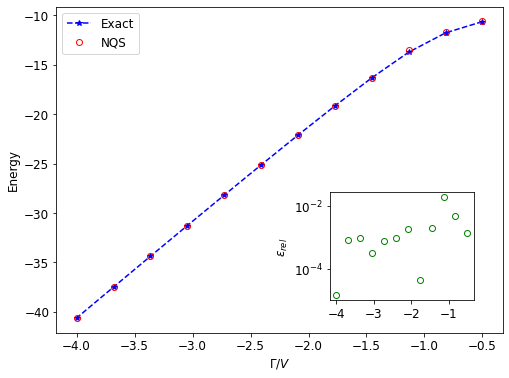

In [6]:
fig, ax1 = plt.subplots(figsize=(8,6))

ax1.plot(Gamma_vals, Energies_gs, 'b*--',label='Exact')
ax1.plot(Gamma_vals, Energies_gs_NQS,'ro',label='NQS',fillstyle='none')
ax1.set_xlabel(r'$\Gamma/V$')
ax1.set_ylabel('Energy')
ax1.legend(loc='upper left')

left, bottom, width, height = [0.6, 0.2, 0.25, 0.25]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.plot(Gamma_vals, np.abs(Energies_gs_NQS - Energies_gs)/np.abs(Energies_gs), 'go',fillstyle='none')
ax2.set_ylabel(r'$\epsilon_{rel}$')
ax2.set_yscale('log')

plt.show()

## 2.2 Netket<a class="anchor" id="netket"></a>

For a tutorial on how to use Netket to learn the ground state of the Ising model and other related techniques. https://netket.readthedocs.io/en/latest/tutorials/gs-ising.html

In [7]:
import jax.numpy as jnp
import flax.linen as nn

In [8]:
class FFN(nn.Module):
    alpha : int = 1
    @nn.compact
    def __call__(self, x):
        dense1 = nn.Dense(features=self.alpha * x.shape[-1])
        dense2 = nn.Dense(2)
        y = dense1(x)
        y = nn.tanh(y)
        y = dense2(y)
        return y[:,0] + 1j*y[:,1]

model = FFN(alpha=3)

# Define the hamiltonian and the hilbert space
hi = nk.hilbert.Spin(s=1/2, N=n_spins)
H_int = sum([-1*sigmaz(hi,i)*sigmaz(hi,(i+1)%n_spins) for i in range(n_spins)])
H_ext = sum([-0.5*sigmax(hi,j) for j in range(n_spins)])
H = H_int + H_ext

sampler = nk.sampler.MetropolisLocal(hi)
vstate = nk.vqs.MCState(sampler, model, n_samples=512*2)
optimizer = nk.optimizer.Momentum(0.08, beta=0.2)
gs = nk.driver.VMC(H, optimizer, variational_state=vstate)

# using Stochastic Reconfiguration method yields more stable results
# gs = nk.driver.VMC(H, optimizer, variational_state=vstate,preconditioner=nk.optimizer.SR(diag_shift=0.1))

log=nk.logging.RuntimeLog()
gs.run(n_iter=1000,out=log)

ffn_energy=vstate.expect(H)

100%|██████████| 1000/1000 [00:56<00:00, 17.82it/s, Energy=-10.6351-0.0007j ± 0.0014 [σ²=0.0017, R̂=1.0067]]
